<a href="https://colab.research.google.com/github/gisela1985/ML_models_practice/blob/main/RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\#Random Forest Regressor - Exercise by Gisela Sanchez
data source: Kaggel

In [2]:
# !pip install pandas_profiling

In [7]:
# !pip install sweetviz
# !pip install numba==0.55.2

# Libraries

In [36]:
#import libraries
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class
import nltk
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
from IPython.core.display import display, HTML
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Goal

In [3]:
# The goal is to predict the price of real estate using the following features:
# LotArea, YearBuilt, 1stFlrSF, 2ndFlrSF, FullBath, BedroomAbvGr, and TotRmsAbvGrd.

# Import data

In [4]:
#define the path where the datasets are
drive_data_path = '/content/drive/MyDrive/ML - Kaggle practice/Data/'

In [5]:
# Read the data
X_full = pd.read_csv(drive_data_path+'train.csv', index_col='Id')
X_test_full = pd.read_csv(drive_data_path+'test.csv', index_col='Id')

# Obtain target and predictors
y = X_full.SalePrice

#reduce el scope to this features
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()

# EDA

In [6]:
#classify columns into categorical and quantitative variables
#define the function
def check_variables(df: pd.DataFrame):
    cols = df.columns
    quantitative_cols = df._get_numeric_data().columns
    categorical_cols = list(set(cols) - set(quantitative_cols))
    return categorical_cols, list(set(quantitative_cols))

In [7]:
#call the function and the save the result into a variable

X_fatures_and_target = X_full[features + ['SalePrice']].copy()


df = X_fatures_and_target
cat_cols, quan_cols = check_variables(df)
print(f'categorical columns: {cat_cols}')
print(f'quantitative columns: {quan_cols}')

categorical columns: []
quantitative columns: ['TotRmsAbvGrd', '1stFlrSF', 'SalePrice', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'YearBuilt', 'LotArea']


## Functions


In [8]:
def summarize_by_category(df, category_col, target_col):
    """
    Summarize a categorical variable with counts, percentages,
    and the average of a target numeric variable.

    Parameters:
    - df: pandas DataFrame
    - category_col: str, name of the categorical column (e.g. 'FullBath')
    - target_col: str, name of the numeric target column (e.g. 'SalePrice')

    Returns:
    - DataFrame with category, count, percentage, and average target value
    """

    # Count and percentage
    summary_df = df[category_col].value_counts().reset_index()
    summary_df.columns = [category_col, 'Count']
    summary_df['percentage'] = round(100 * summary_df['Count'] / summary_df['Count'].sum(), 2)

    # Average of target variable
    avg_target = df.groupby(category_col)[target_col].mean().reset_index()
    avg_target.columns = [category_col, f'Avg_{target_col}']

    # Merge summaries
    summary_df = summary_df.merge(avg_target, on=category_col)
    summary_df[f'Avg_{target_col}'] = summary_df[f'Avg_{target_col}'].round(2)

    return summary_df


In [9]:
def plot_horizontal_bar(
    df, x_col, y_col,
    xlabel='', ylabel='', title='',
    bar_color='mediumseagreen',
    value_suffix='%',  # suffix to show next to bar values, e.g. '%', '', '$'
    value_offset=0.5,  # horizontal offset for values from the bar end
    figsize=(8,6)
):
    """
    Plot a horizontal bar chart with values annotated on bars and integer y-axis ticks.

    Parameters:
    - df: DataFrame containing the data
    - x_col: column name for y-axis categories (bars)
    - y_col: column name for x-axis values (bar lengths)
    - xlabel, ylabel, title: axis labels and title
    - bar_color: color of the bars
    - value_suffix: suffix to add to annotated values
    - value_offset: horizontal distance between bar end and value text
    - figsize: tuple with figure size
    """

    df = df.head(10).copy()
    plt.figure(figsize=figsize)
    bars = plt.barh(df[x_col], df[y_col], color=bar_color)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Force y-axis to show integer ticks if y-axis values are numeric
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Add values on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + value_offset,
                 bar.get_y() + bar.get_height() / 2,
                 f'{width:.2f}{value_suffix}',
                 va='center')

    plt.tight_layout()
    plt.show()

In [10]:
def scater_plot_variables(df, var1, var2):
  plt.figure(figsize=(8, 6))
  plt.scatter(df[var1], df[var2], color='tomato', s=80)

  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.title(f'Sale Price by {var1}')
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

In [11]:
def group_functions(var_to_analyze, target):
  df_variable = summarize_by_category(df, var_to_analyze, target)
  display(df_variable.head(10))

  plot_horizontal_bar(
      df=df_variable,
      x_col=var_to_analyze,
      y_col='percentage',
      xlabel='Percentage (%)',
      ylabel=f'Number of {var_to_analyze}',
      title= f'Percentage of {var_to_analyze}',
      bar_color='mediumseagreen',
      value_suffix='%',
      value_offset=0.5
  )

  variables = [var_to_analyze, 'Avg_SalePrice']
  scater_plot_variables(df_variable, variables[0], variables[1])

  variables = [var_to_analyze, target]
  q_99 = df[var_to_analyze].quantile(0.99)
  df_no_outliers = df[df[var_to_analyze] <= q_99]
  scater_plot_variables(df_no_outliers, variables[0], variables[1])

## Features

Feature: LotArea


,LotArea,Count,percentage,Avg_SalePrice
0,7200,25,1.71,130238.00
1,9600,24,1.64,148350.00
2,6000,17,1.16,113752.94
3,9000,14,0.96,154199.14
4,8400,14,0.96,149714.29
5,10800,14,0.96,159928.57
6,1680,10,0.68,101640.00
7,7500,9,0.62,159988.89
8,9100,8,0.55,151154.62
9,8125,8,0.55,189493.75


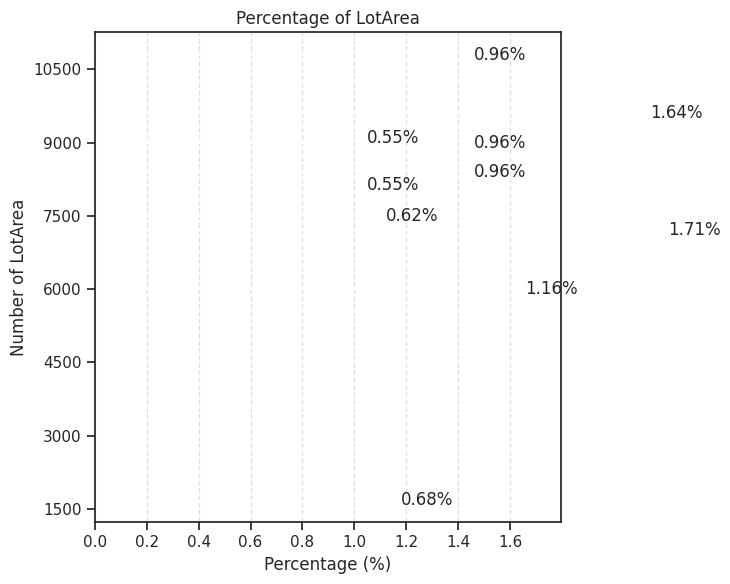

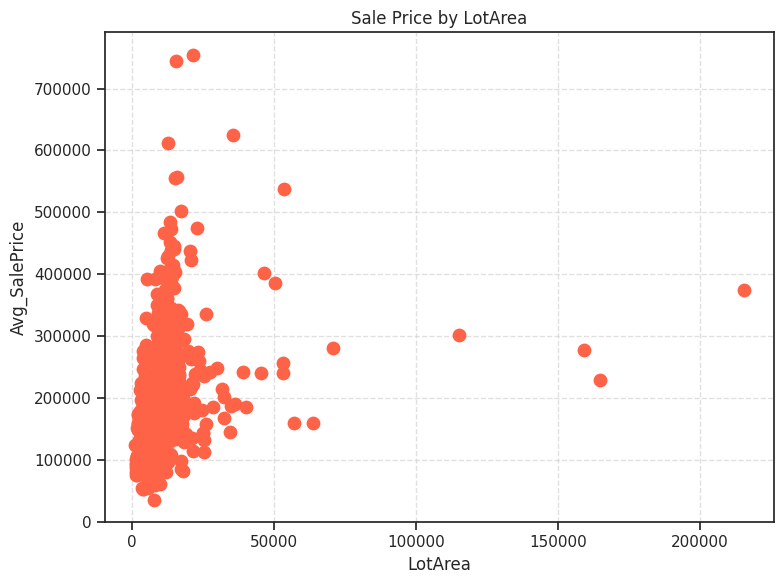

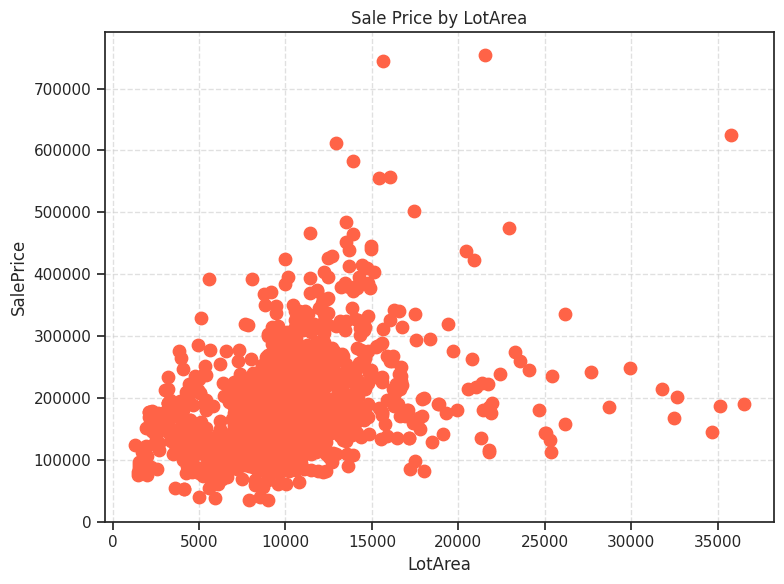

Feature: YearBuilt


,YearBuilt,Count,percentage,Avg_SalePrice
0,2006,67,4.59,251775.45
1,2005,64,4.38,229680.95
2,2004,54,3.70,210347.72
3,2007,49,3.36,255362.73
4,2003,45,3.08,227408.58
5,1976,33,2.26,163831.97
6,1977,32,2.19,166860.94
7,1920,30,2.05,112903.33
8,1959,26,1.78,154124.31
9,1998,25,1.71,220450.00


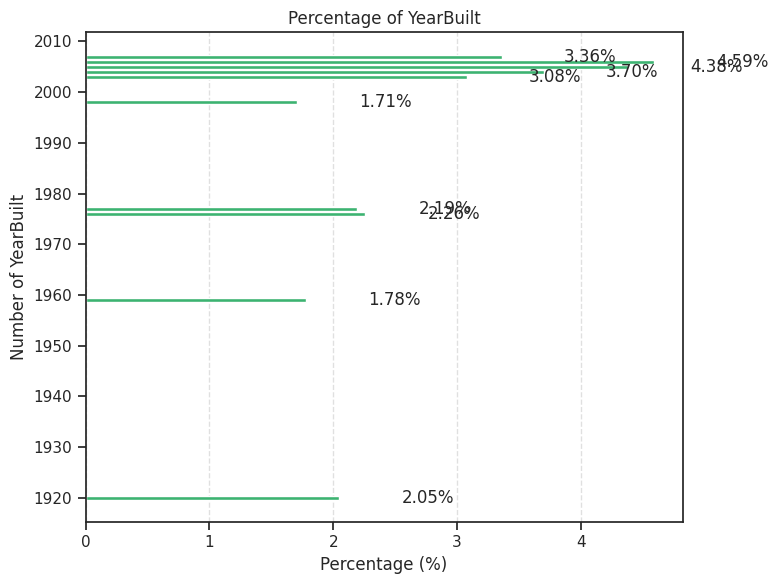

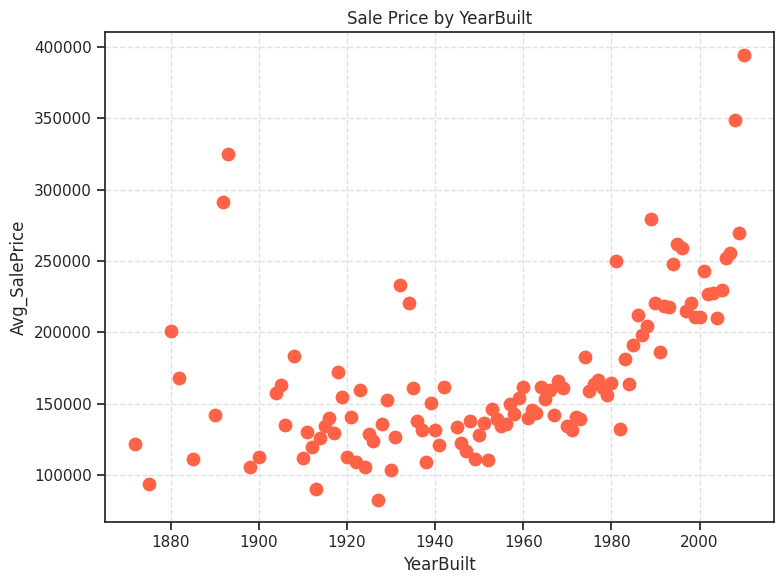

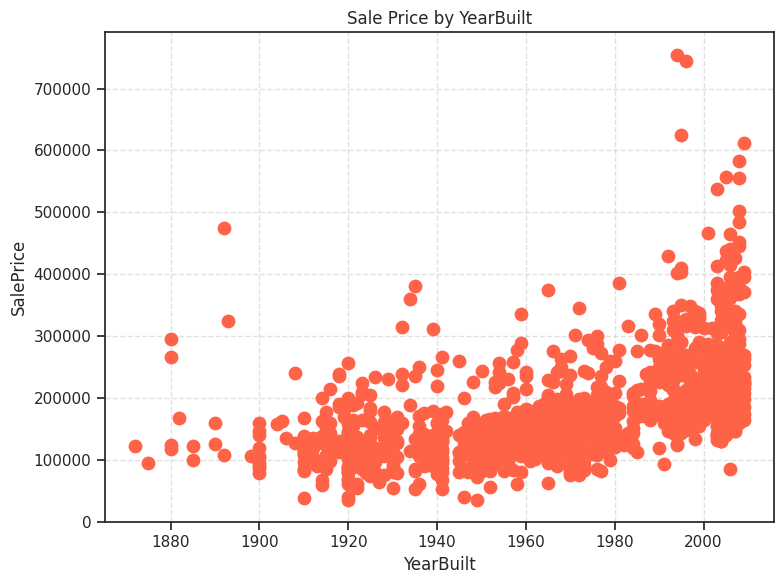

Feature: 1stFlrSF


,1stFlrSF,Count,percentage,Avg_SalePrice
0,864,25,1.71,122759.32
1,1040,16,1.10,124828.12
2,912,14,0.96,148425.00
3,894,12,0.82,131716.67
4,848,12,0.82,141427.83
5,672,11,0.75,116572.73
6,630,9,0.62,92944.44
7,816,9,0.62,120711.11
8,483,7,0.48,96628.57
9,960,7,0.48,133321.43


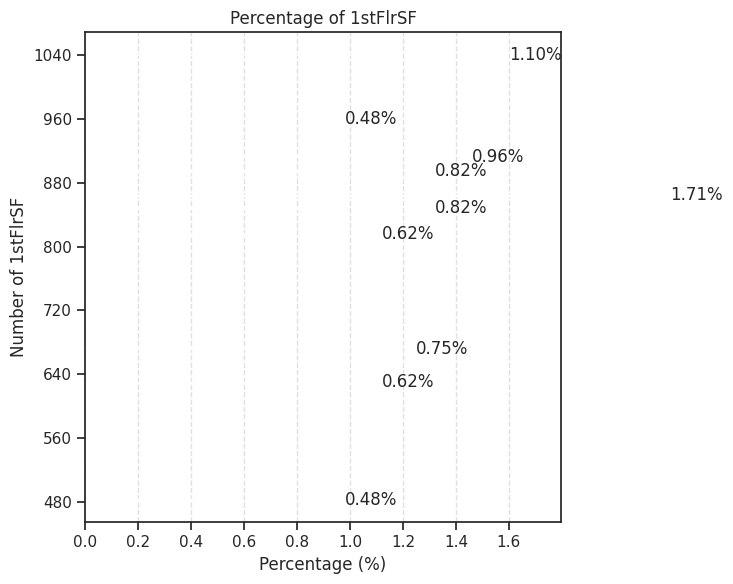

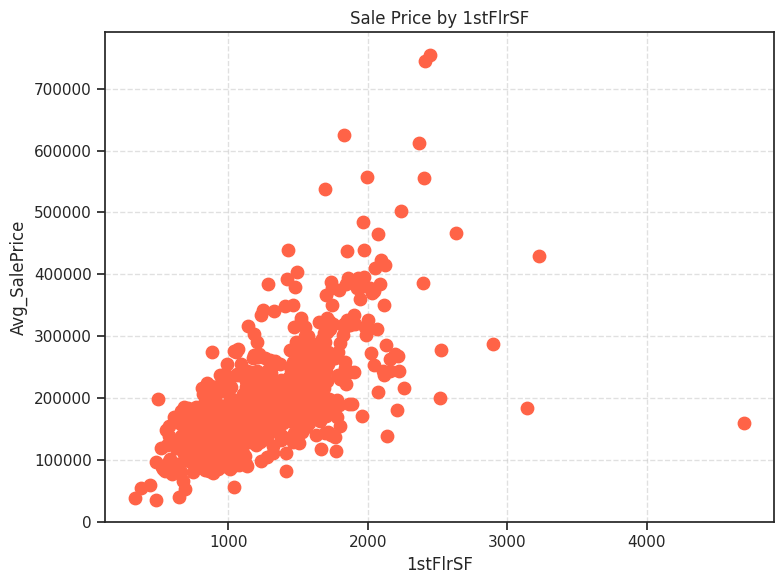

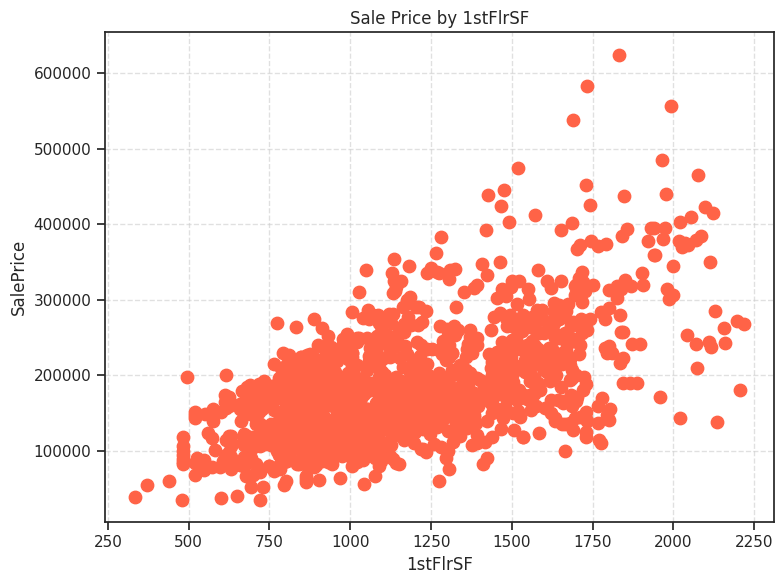

Feature: 2ndFlrSF


,2ndFlrSF,Count,percentage,Avg_SalePrice
0,0,829,56.78,171383.67
1,728,10,0.68,168815.00
2,504,9,0.62,113322.22
3,546,8,0.55,95437.50
4,672,8,0.55,131441.75
5,600,7,0.48,134986.00
6,720,7,0.48,152357.14
7,896,6,0.41,192900.00
8,862,5,0.34,165700.00
9,780,5,0.34,199580.00


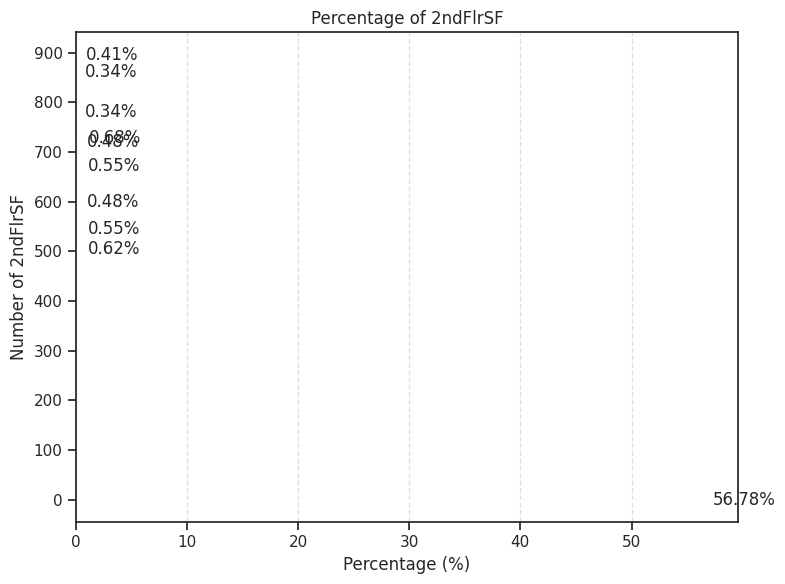

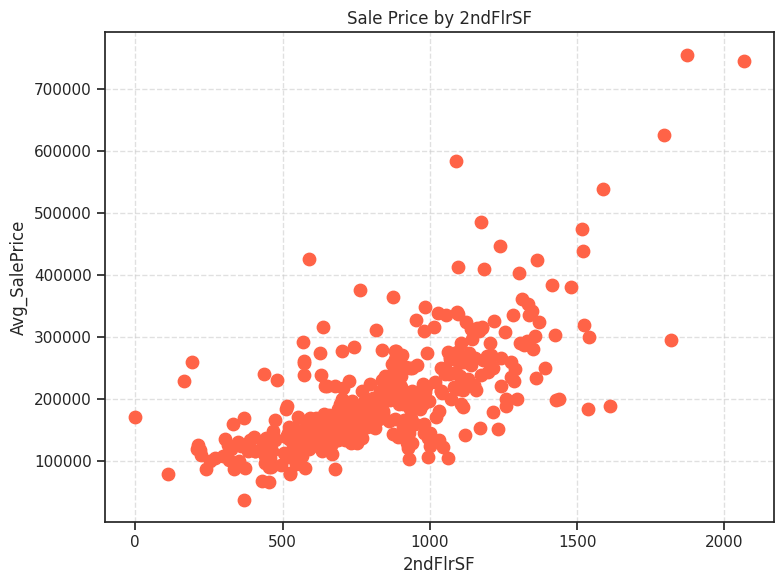

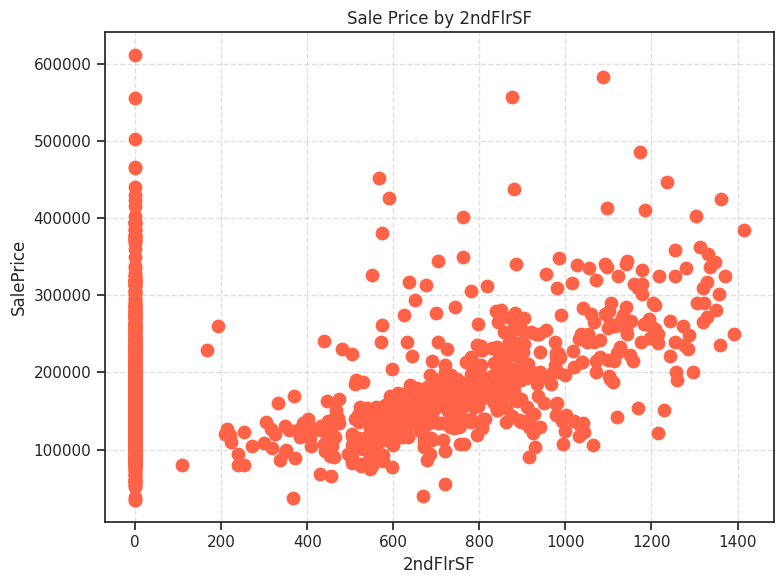

Feature: FullBath


,FullBath,Count,percentage,Avg_SalePrice
0,2,768,52.60,213009.83
1,1,650,44.52,134751.44
2,3,33,2.26,347822.91
3,0,9,0.62,165200.89


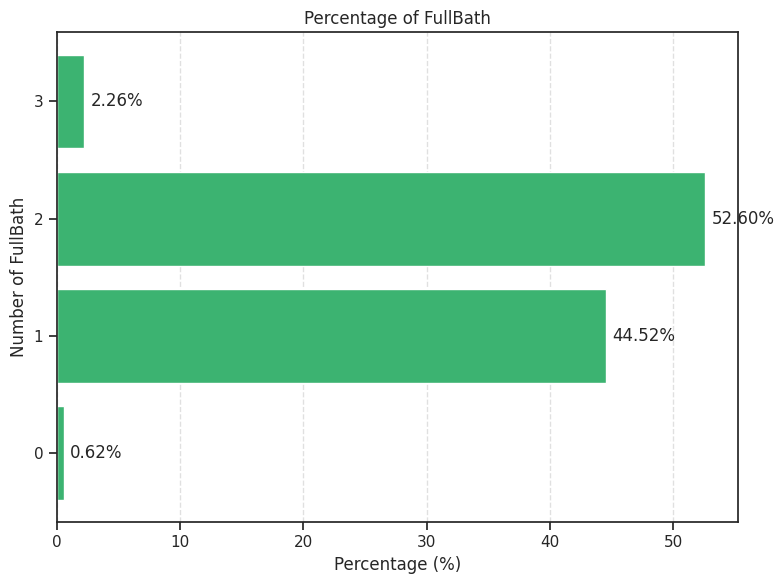

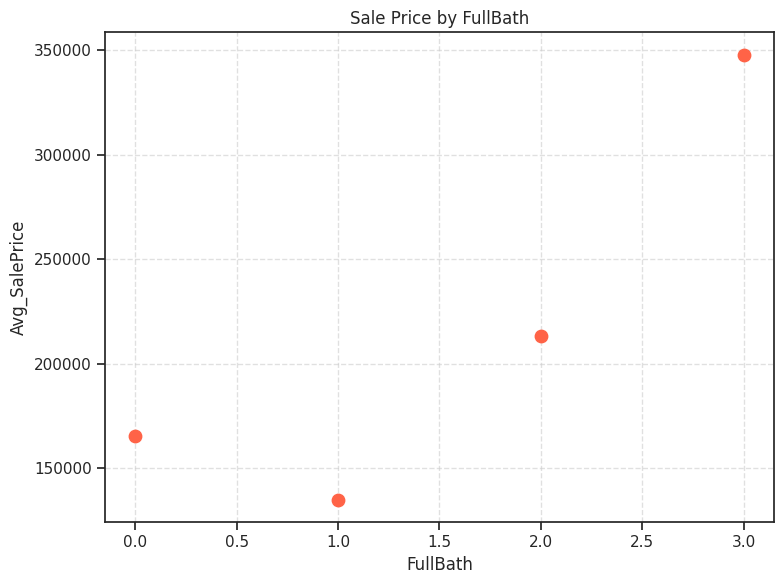

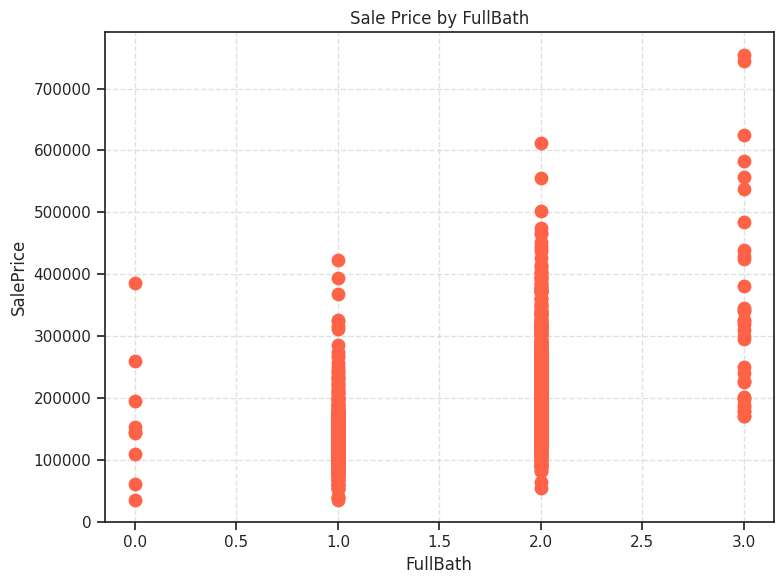

Feature: BedroomAbvGr


,BedroomAbvGr,Count,percentage,Avg_SalePrice
0,3,804,55.07,181056.87
1,2,358,24.52,158197.66
2,4,213,14.59,220421.25
3,1,50,3.42,173162.42
4,5,21,1.44,180819.05
5,6,7,0.48,143779.00
6,0,6,0.41,221493.17
7,8,1,0.07,200000.00


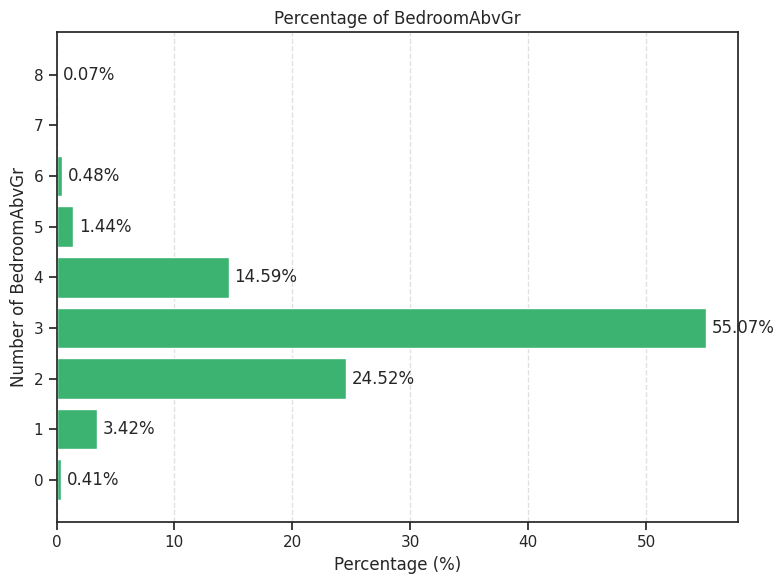

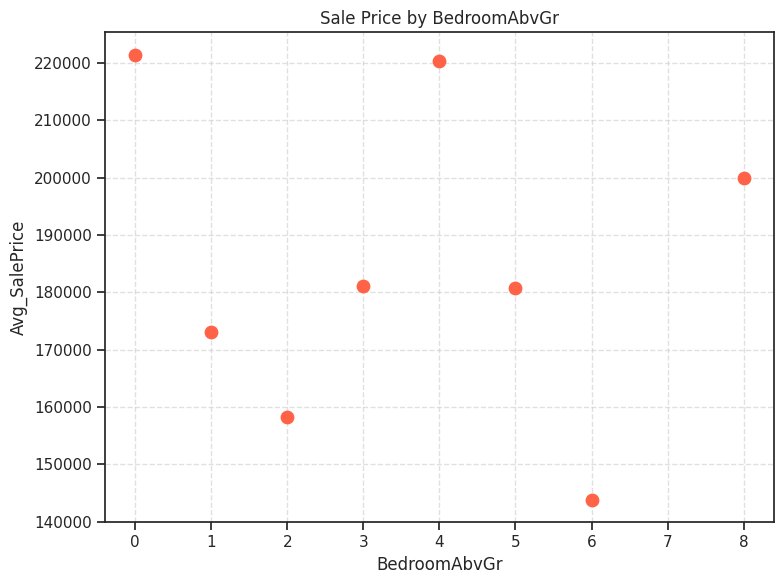

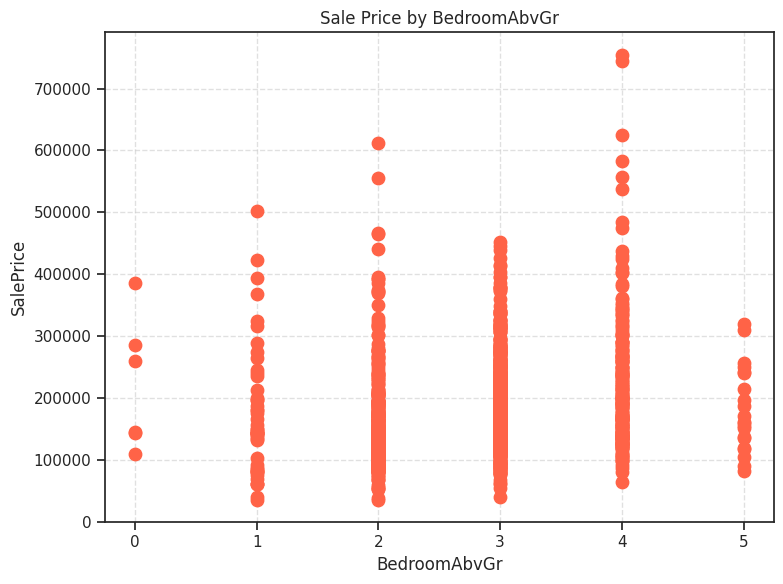

Feature: TotRmsAbvGrd


,TotRmsAbvGrd,Count,percentage,Avg_SalePrice
0,6,402,27.53,161303.30
1,7,329,22.53,196666.78
2,5,275,18.84,141550.75
3,8,187,12.81,213427.53
4,4,97,6.64,122844.63
5,9,75,5.14,252988.17
6,10,47,3.22,296279.17
7,11,18,1.23,318022.00
8,3,17,1.16,111217.65
9,12,11,0.75,280971.45


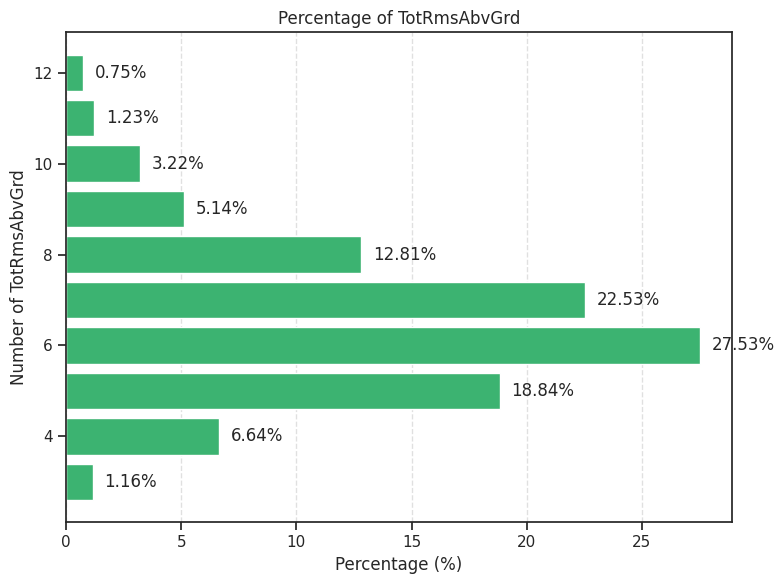

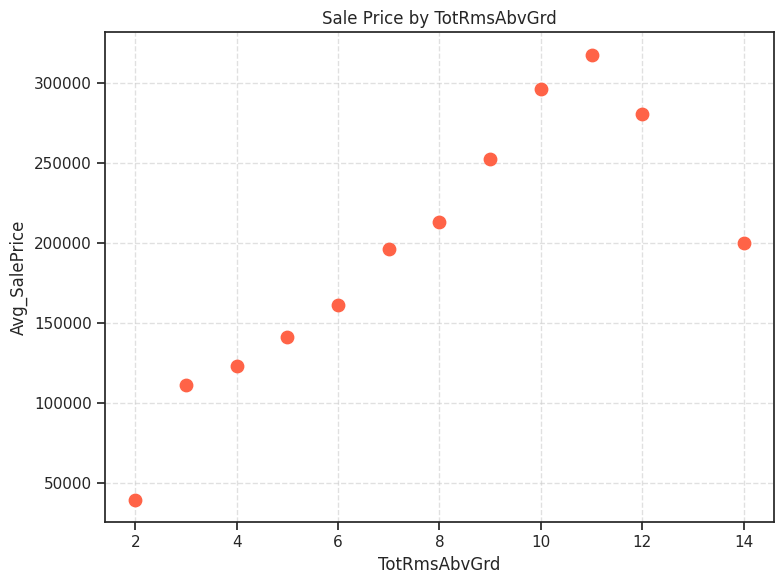

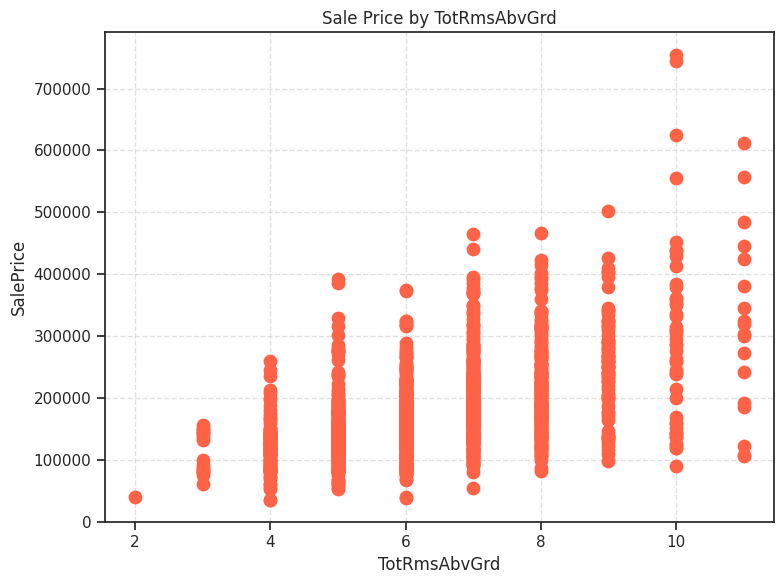

In [12]:
for feature in features:
  print(f'Feature: {feature}')
  var_to_analyze = feature
  target = 'SalePrice'

  group_functions(var_to_analyze, target)

# Auto EDA

In [24]:
sweetviz_report = sv.analyze(df)
sweetviz_report.show_html('report_EDA.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report_EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



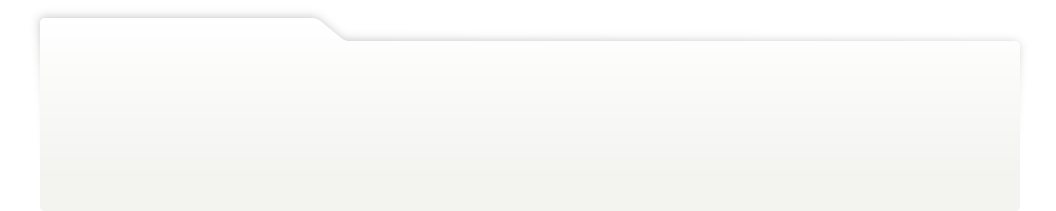
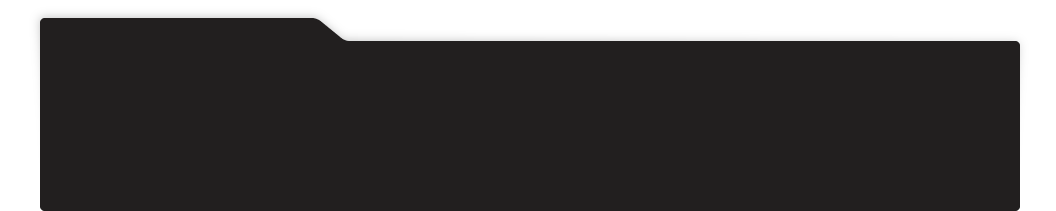
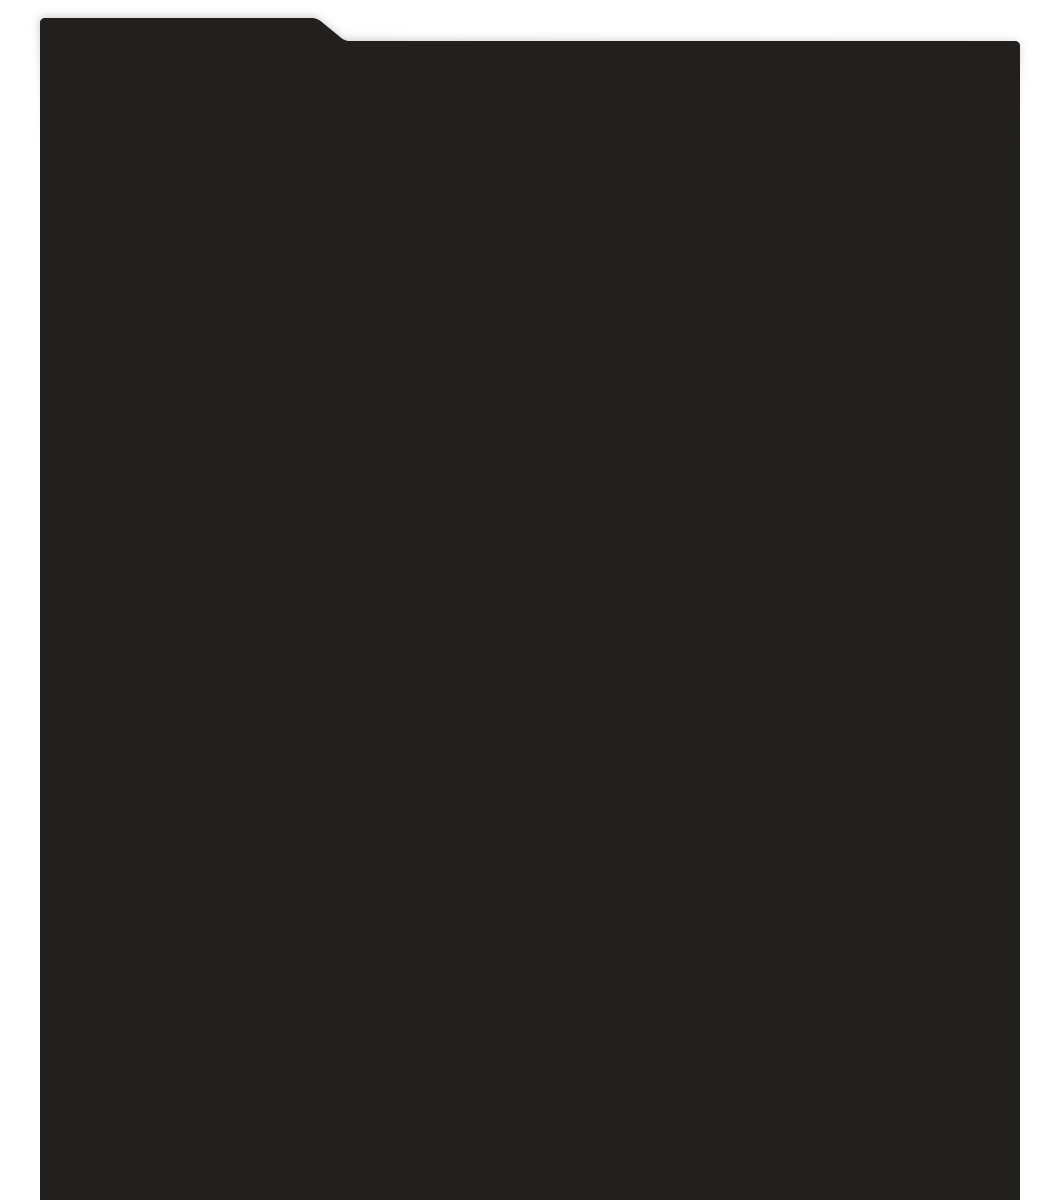
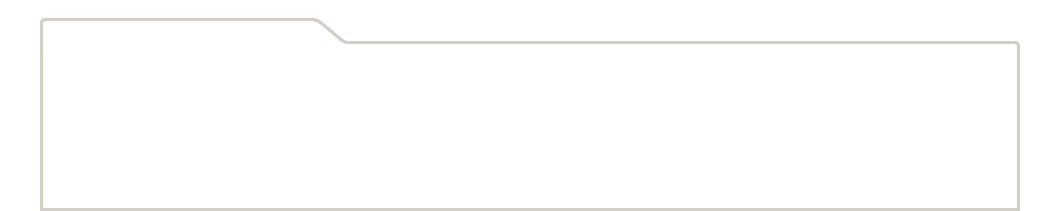
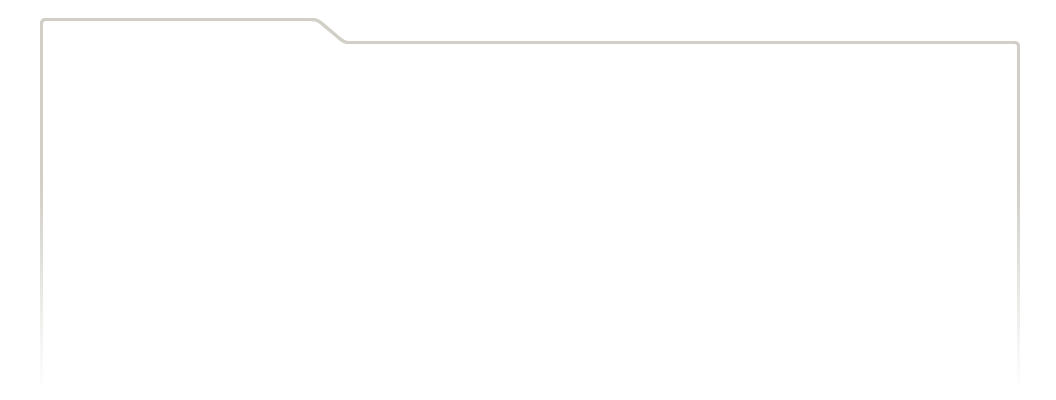
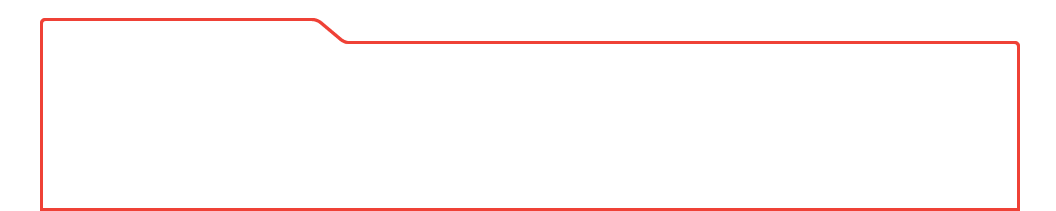
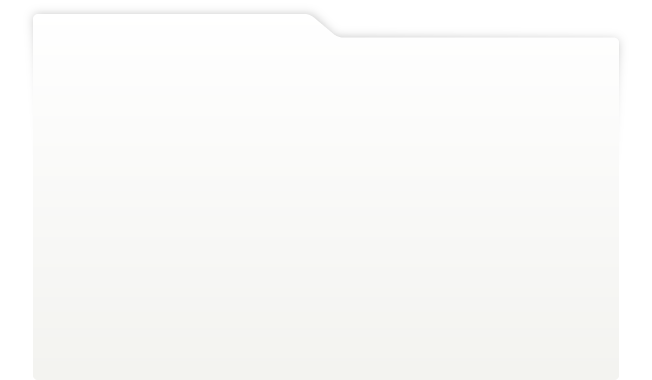
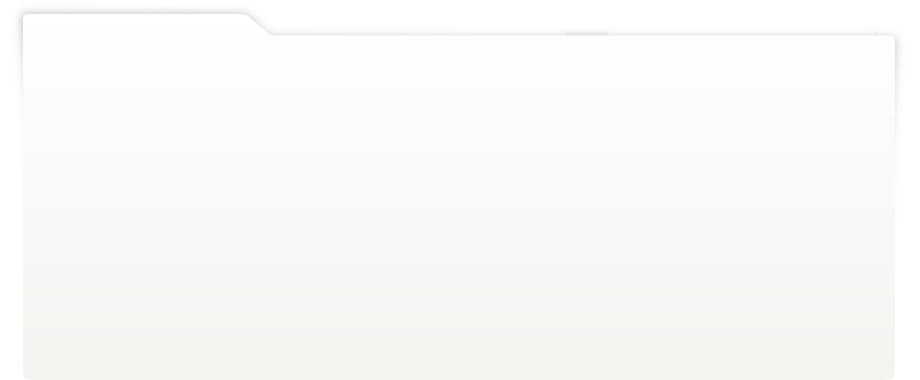
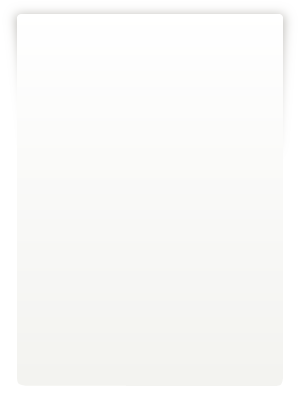
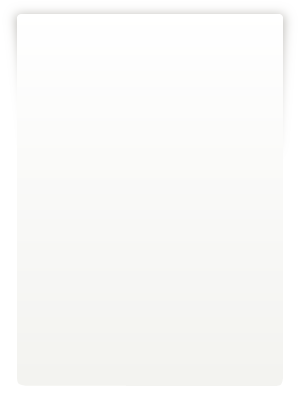
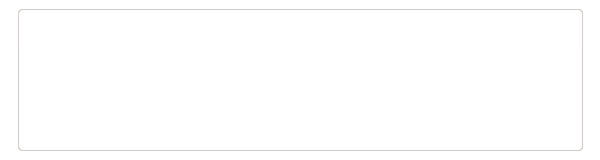
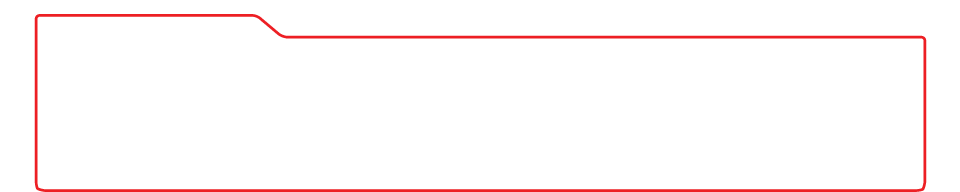
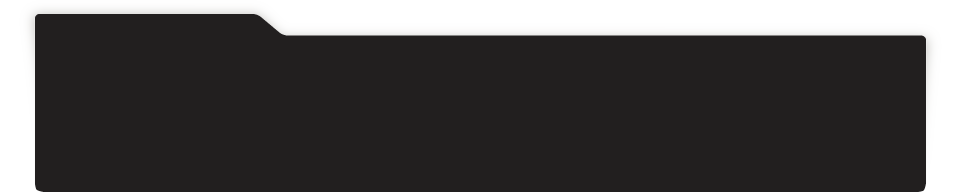
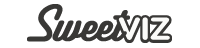
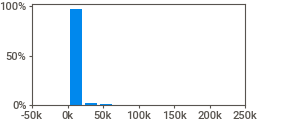
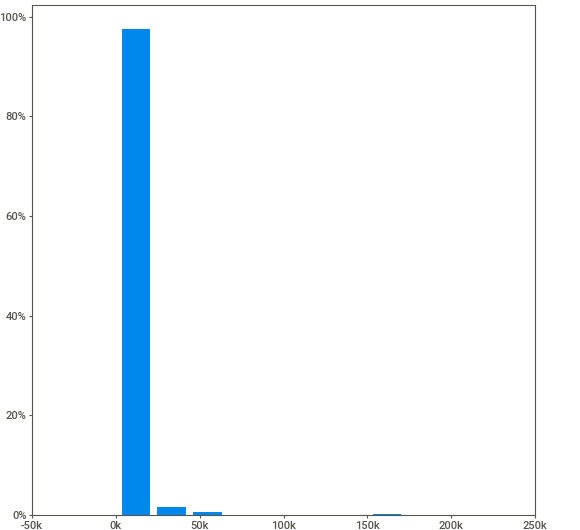
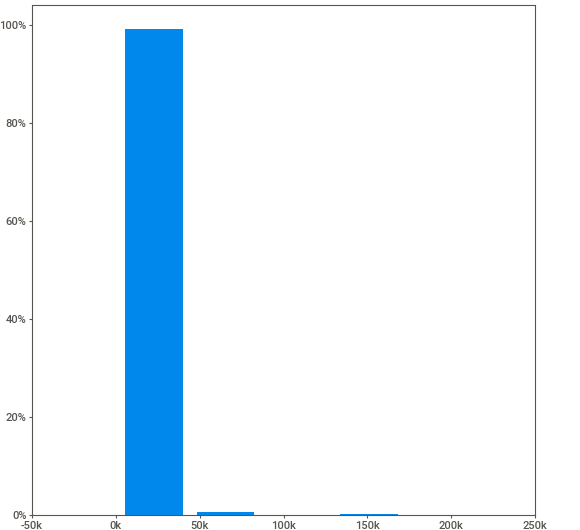
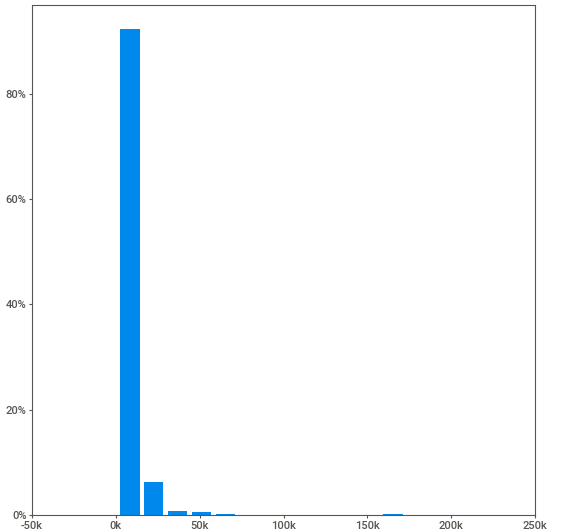
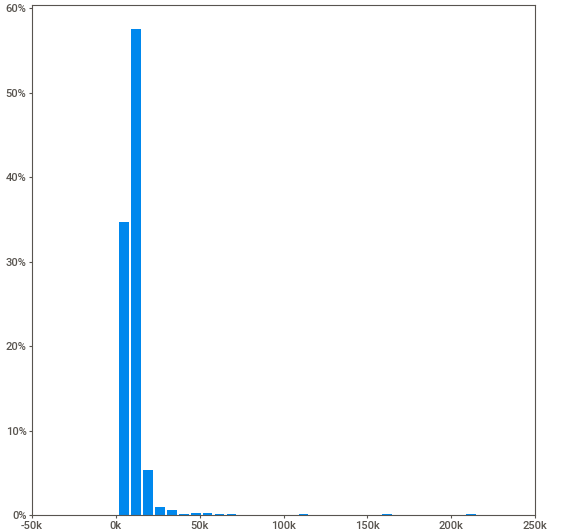
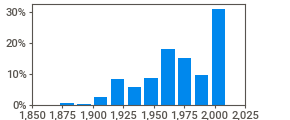
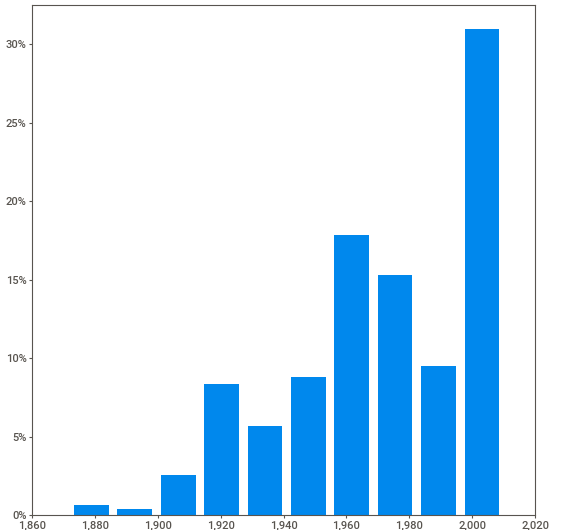
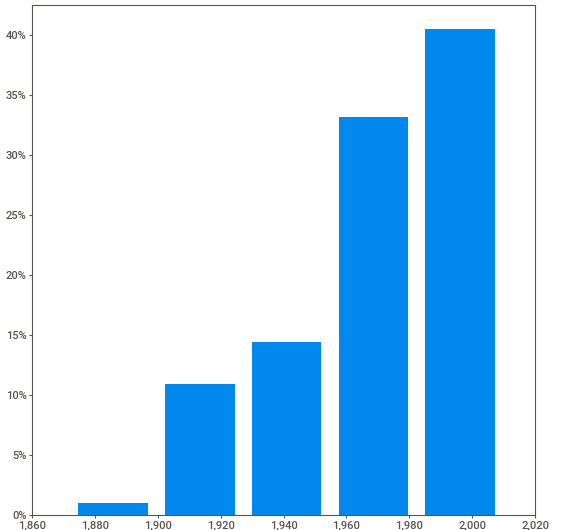
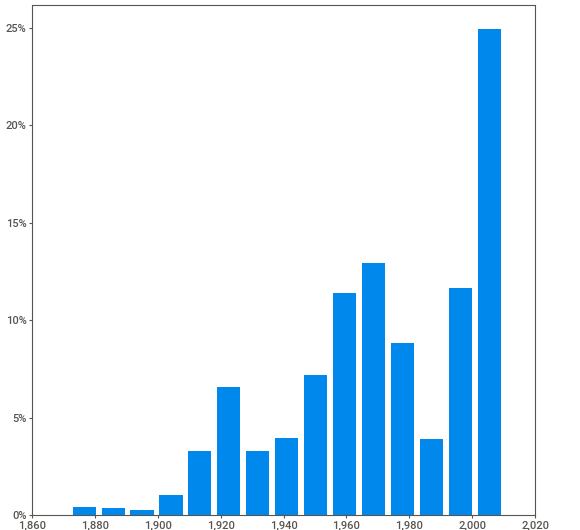
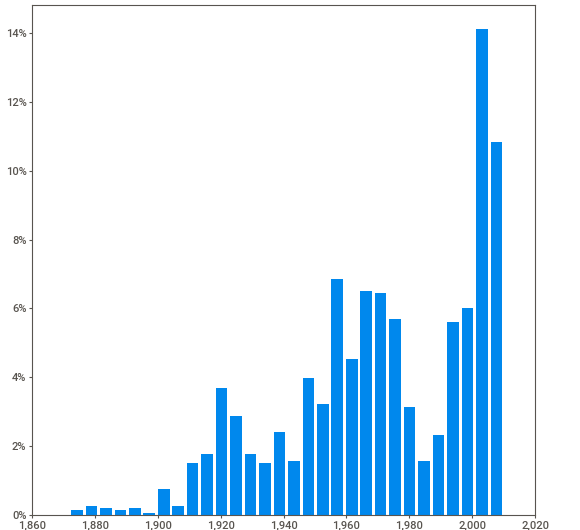
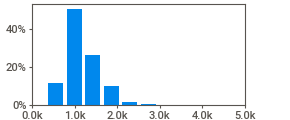
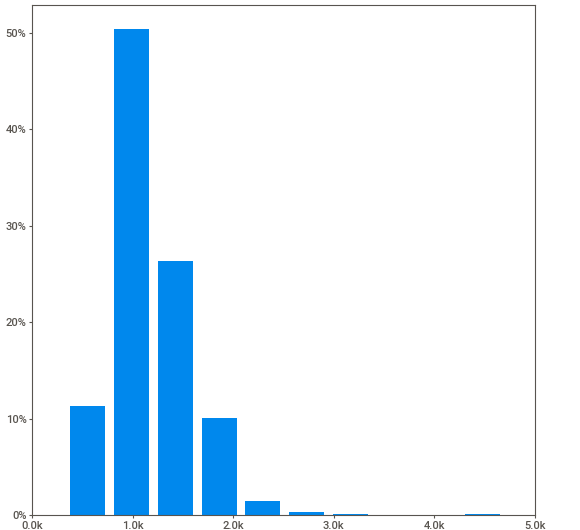
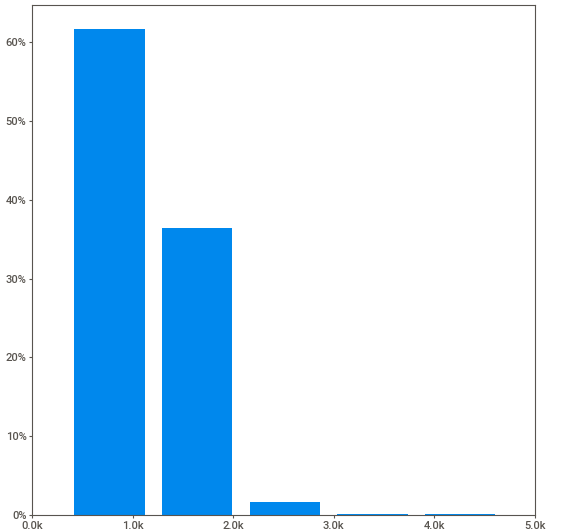
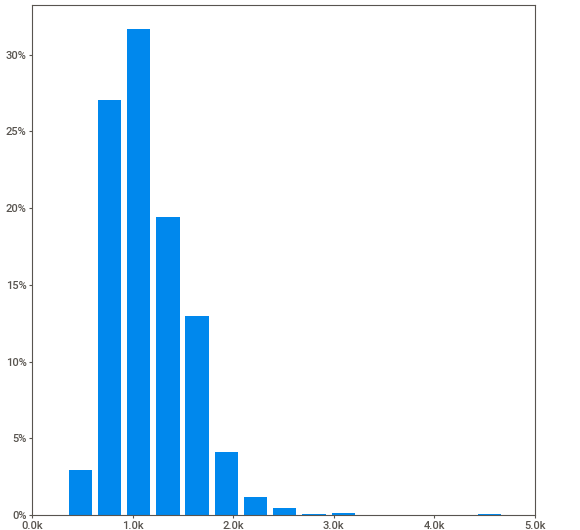
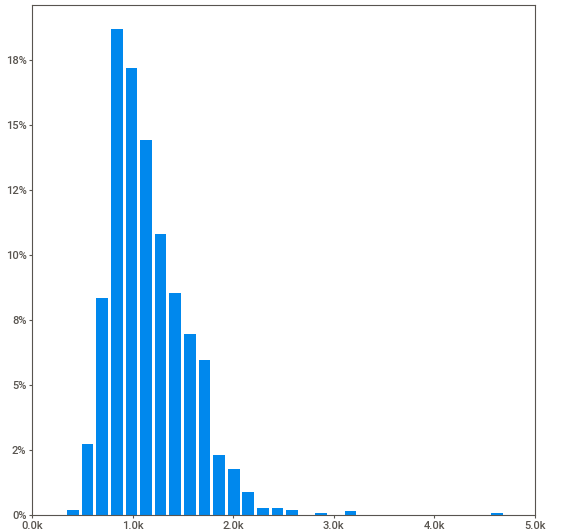
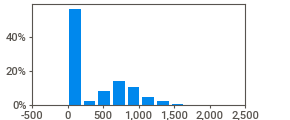
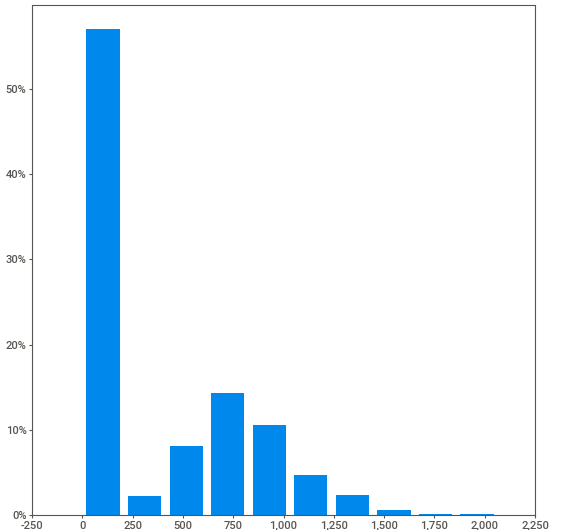
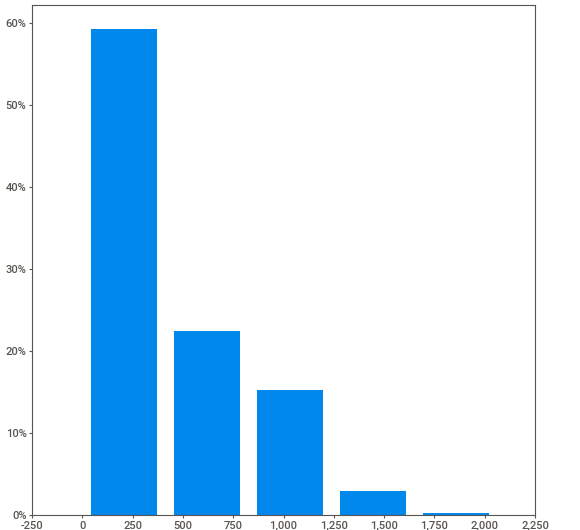
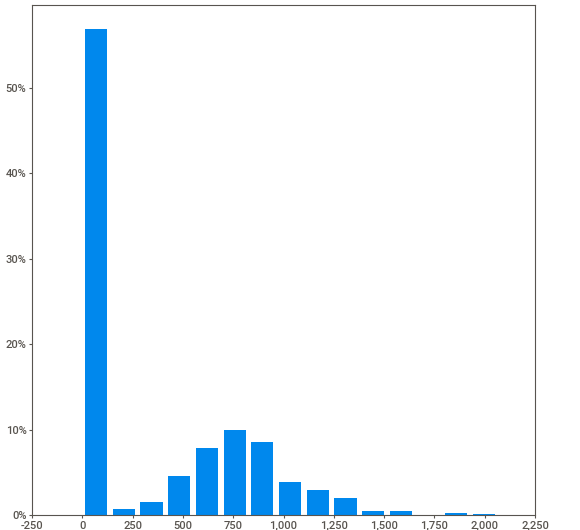
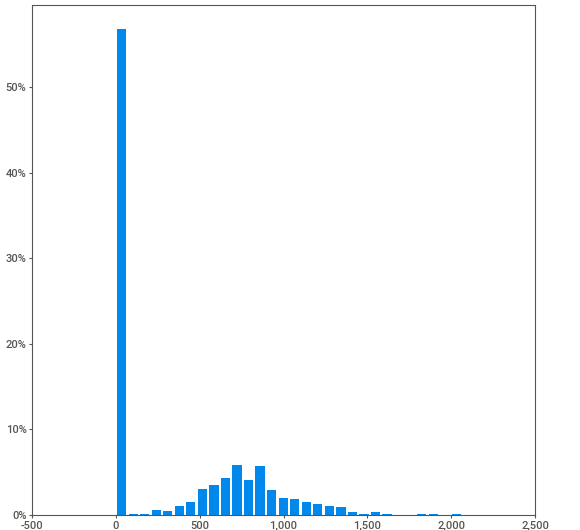
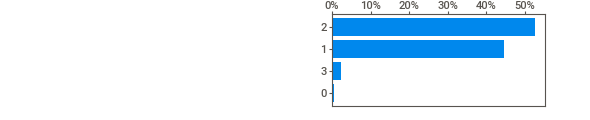
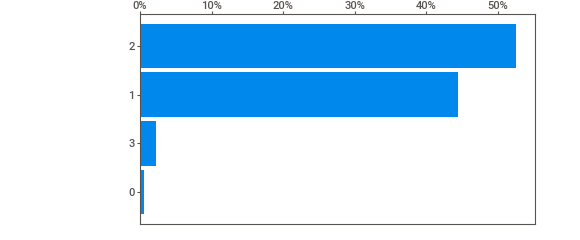
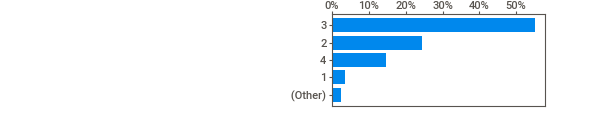
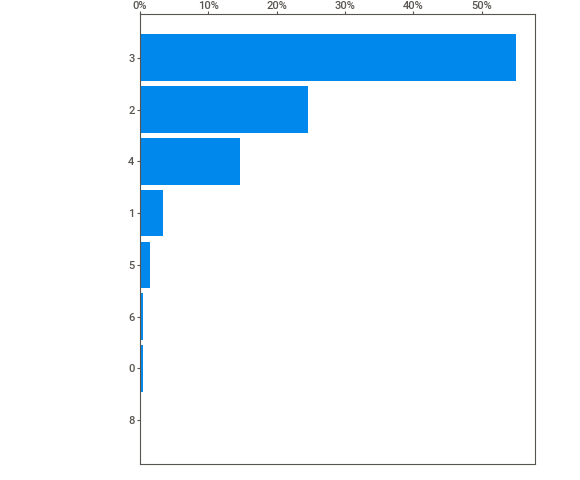
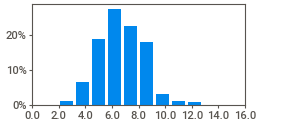
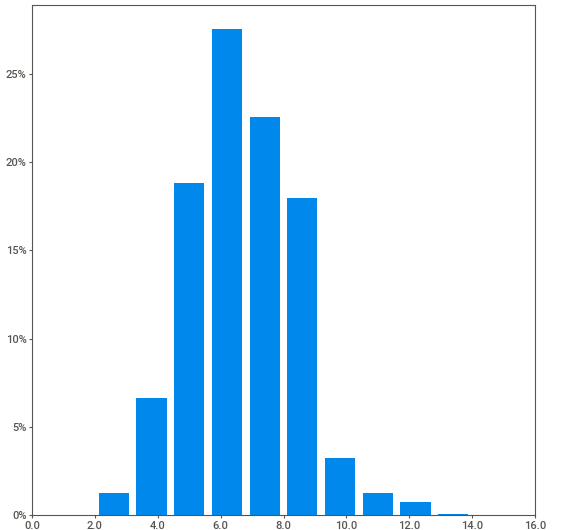
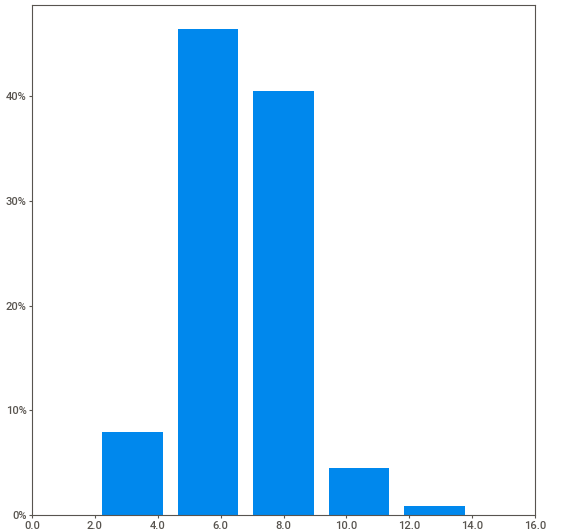
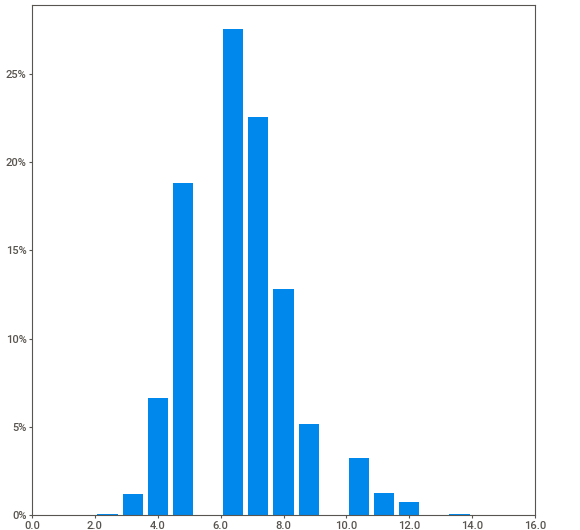
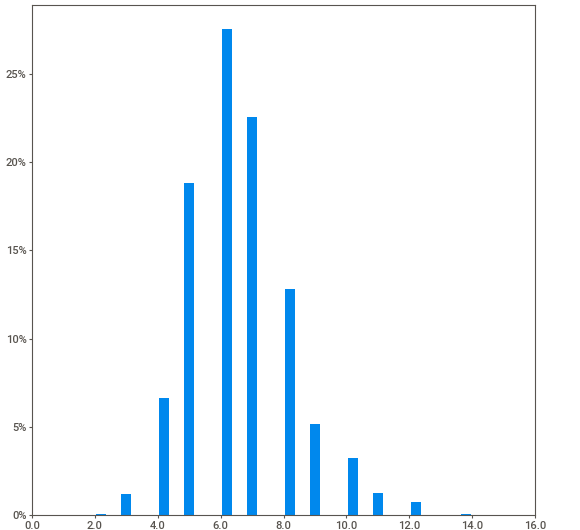
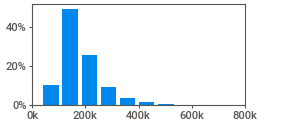
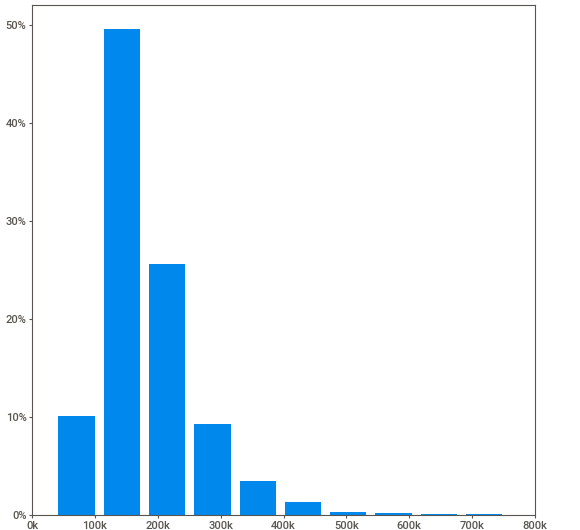
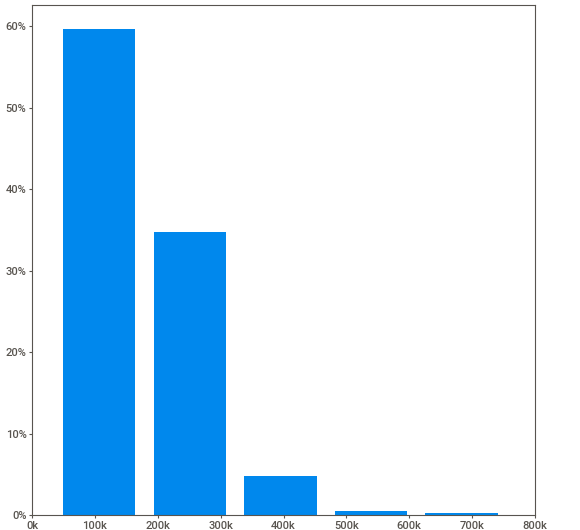
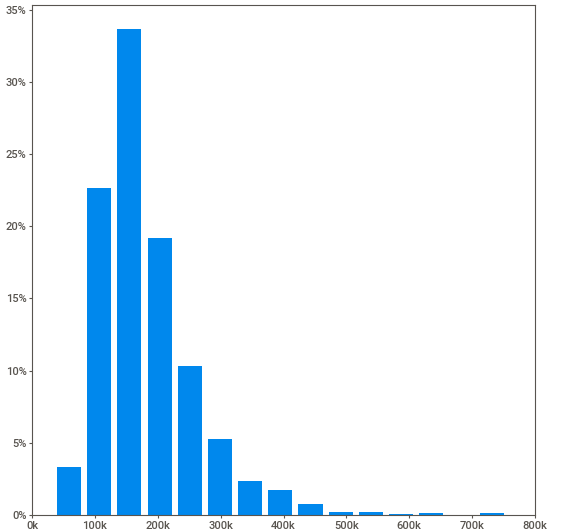
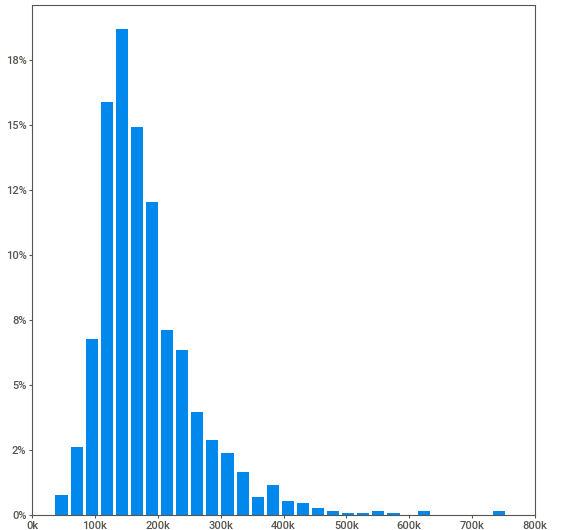
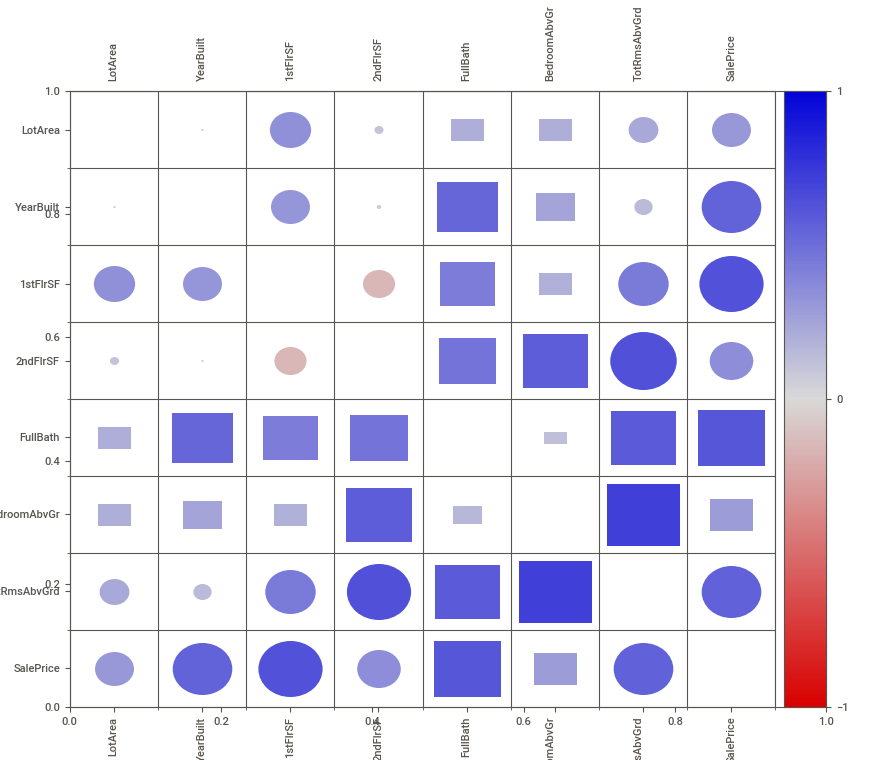
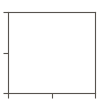

In [22]:
with open("/content/report_EDA.html", "r") as f:
    html_content = f.read()

display(HTML(html_content))

# Model

In [25]:
# split the data with randomization
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    test_size=0.2,
    shuffle=True,
    random_state=42  # set a seed for reproducibility
)

In [26]:
#show the head of train and test data
print("Data Train")
display(X_train.head())
print("Data Test")
display(X_test.head())

Data Train


,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd
Id,,,,,,,
255,8400,1957,1314,0,1,3,5
1067,7837,1993,799,772,2,3,7
639,8777,1910,796,0,1,2,4
800,7200,1937,981,787,1,3,7
381,5000,1924,1026,665,2,3,6


Data Test


,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd
Id,,,,,,,
893,8414,1963,1068,0,1,3,6
1106,12256,1994,1500,1122,2,3,9
414,8960,1927,1028,0,1,2,5
523,5000,1947,1004,660,2,3,7
1037,12898,2007,1620,0,2,2,6


In [27]:
#show the head of train and test data
print("Data Train")
display(y_train.head())
print("Data Test")
display(y_test.head())

Data Train


,SalePrice
Id,
255,145000
1067,178000
639,85000
800,175000
381,127000


Data Test


,SalePrice
Id,
893,154500
1106,325000
414,115000
523,159000
1037,315500


In [28]:
#show the shape of the data
print("Data Train - shape")
display(X_train.shape)
print("Data Test - shape")
display(X_test.shape)

Data Train - shape


(1168, 7)

Data Test - shape


(292, 7)

In [39]:
# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

# Model Selectio

In [34]:
# Define SMAPE function
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # avoid division by zero
    return np.mean(diff) * 100

# Function to evaluate and return multiple metrics
def score_model(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)

    mae = mean_absolute_error(y_v, preds)
    smape_val = smape(np.array(y_v), np.array(preds))
    r2 = r2_score(y_v, preds)

    return mae, smape_val, r2

In [69]:
# Initialize list to store results
results = []

# Loop through models and collect metrics
for i, model in enumerate(models):
    mae, smape_val, r2 = score_model(model)
    results.append({
        'Model_name': f'model_{i+1}',
        'Model': model,
        'MAE': round(mae, 2),
        'SMAPE': round(smape_val, 2),
        'R2': round(r2, 3)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df[['Model_name','MAE','SMAPE','R2']]


,Model_name,MAE,SMAPE,R2
0,model_1,22325.59,12.96,0.860
1,model_2,22435.75,12.99,0.859
2,model_3,22666.73,13.07,0.854
3,model_4,22915.25,13.05,0.837
4,model_5,22901.50,13.22,0.853


In [67]:
##pick the model with lower MAE
min_MAE = results_df.MAE.min()
winner_model_name = results_df[results_df.MAE==min_MAE].Model_name.values[0]
display(winner_model_name)
winner_model = results_df[results_df.MAE==min_MAE].Model.values[0]
results_df[results_df.MAE==min_MAE].Model.values[0]

'model_1'

RandomForestRegressor(n_estimators=50, random_state=0)

In [68]:
# Fit the model to the training data
my_model = winner_model
my_model.fit(X, y)

# Generate test predictions
preds_test = my_model.predict(X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)